# Artificial Bee Colony (ABC) for the TSP

* **File:** ABC_algorithm_TSP.ipynb
* **Author:** Angel Sanz Gutierrez
* **Contact:** sanzangel017@gmail.com
* **GitHub:** AngelS017
* **Description:** All the code of the proyect, the study and the final conclusions
* **Version:** 1.0

This file is part of ABC algorithm for TSP, which is licensed under the MIT License.
See the LICENSE file in the project root for more information.


Now you will see a brief explanetion about how it works the ABC algorithm, the original paper was written by Karaboga, 2005. We need to take into account that the original 
algorithm was developed for optimizations of continuous problems but in the Travel Salesman Problem (TSP) we are working with discrete optimizations, as we need to optimize 
a route from different cities.

That´s why the pseudocode of the algorithm is not the same as in the original paper.


Explanation of the algorithm:
1. Initialize the population:

    Each bee will create a random path and calculate its distance and all other necessary parameters.
    Also the bees will have a role assigned.

2. While the number of epochs is not reached:
    1. Employed bee behaviour:
        
        The bees that have the rol of employed will generate a new solution and if the new solution it´s better than the old one the bee will update its path and distance path.  

    2. Calculate the probability of each solution:
        
        All the solutions will have a probability to be choosed in the next phase of the algorithm, to calculate the probability we need to divide the distance  of each solution 
        by the sum of all distance paths.

    3. Onlooker bee behaviour:

        The bees that have the rol of onlooker will choose the best solution using the roulette wheel selection and a new solution its generated and if the new solution  it is better than the old one the bee will update its path and distance path.

    4. Scout bee behaviour:

        If a bee has reached the number of trials to work with a solution, it will be eliminated and a new one will be generated with a randomised path.

3. Report the best path found and the distance of that path


> [!NOTE]: Generate new solutions
> To generate a new solutions in the TSP there are different technics, thats the idea of the project, create an ABC algorithm to work with a bounch of them.

## Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance # for euclidian distance

import abc_tsp

#from ArtificialBeeColony_TSP.abc_tsp.ArtificialBeeColony_TSP import ArtificialBeeColonyOptimizer

## Read dataset

The data that we are going to use in this proyect will be obtein from a web call [National TSP](https://www.math.uwaterloo.ca/tsp/world/countries.html) from the University of Waterloo.

Each dataset conteins a  number of cities which are represented with their X and Y coordinates.


In this case we are going to work with the dataset of the country Luxembourg.

In [3]:
cities = pd.read_csv("data/lu980.tsp", sep=" ", skiprows=7, header=None, names=["Coord X", "Coord Y"])
cities = cities.iloc[:-1]
print("In our dataset there are {0} cities".format(cities.shape[0]))
cities

In our dataset there are 980 cities


,Coord X,Coord Y
1,49525.5556,5940.5556
2,49525.5556,5940.5556
3,49738.8889,6345.0000
4,49608.3333,6405.8333
5,49796.6667,6155.5556
...,...,...
976,50108.0556,5923.3333
977,49880.2778,6221.9444
978,49894.4444,6163.6111
979,49926.6667,6173.6111


## Clean dataset

Our dataset contains 980 cities, but there are some duplicate cities. So after the removal of the duplicate cities, because of the travelling salesman problem, the path can only pass through each city once, 634 cities would be left.

In [4]:
cities_duplicated = cities.duplicated().sum()
print("Number of duplicated cities: ", cities_duplicated)

cities = cities.drop_duplicates()
cities = cities.reset_index(drop=True)
print("\nIn our dataset there are {0} cities after delating the duplicated cities".format(cities.shape[0]))

Number of duplicated cities:  346

In our dataset there are 634 cities after delating the duplicated cities


## Create matrix distance between cities

The cost of traveling between cities is specified by the **Euclidean distance** rounded to the nearest whole number.

In [5]:
distance_matrix = np.round(distance.cdist(cities, cities, 'euclidean')).astype(int)
print("Shape distance matrix: ", distance_matrix.shape)
distance_matrix

Shape distance matrix:  (634, 634)


array([[  0, 457, 473, ..., 162, 414, 402],
       [457,   0, 144, ..., 355, 208, 501],
       [473, 144,   0, ..., 332,  93, 614],
       ...,
       [162, 355, 332, ...,   0, 261, 490],
       [414, 208,  93, ..., 261,   0, 617],
       [402, 501, 614, ..., 490, 617,   0]])

## Other functions

In [6]:
def history_best_paths_distances(paths_distances, employed_strategy, onlooker_strategy, xlabel='Epochs', ylabel='Best path distances', title='Evolution of path distances'):
    """Plot the distance of the best path found in each epoch during the training.

     Parameters
     ----------
     paths_distances : array-like
          The distance of the best path of each epoch during the training process.
          
     employed_strategy : str
          The stategy use in the employed bees behaviour.
     
     onlooker_strategy: str
          The stategy use in the onlooker bees behaviour.
     
     xlabel : str, default=Epochs
          The name to put in the xlabel of the plot.

     ylabel : str, default=Best path distances
          The name to put in the ylabel of the plot.

     title : str, default=Evolution of path distances
          The title of the plot.

     Returns
     -------

     """
    plt.plot(paths_distances)
    plt.scatter(np.argmin(paths_distances), np.min(paths_distances), color='red')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend([f'Min distance: {np.min(paths_distances)}'])
    plt.text(1.05, 0.5, 
         f"Employed strategy:\n{employed_strategy}\n\n"
         f"Onlooker strategy:\n{onlooker_strategy}",
         transform=plt.gca().transAxes,
         verticalalignment='center', 
         horizontalalignment='left',
         fontsize=10,
         fontstyle='normal',
         bbox=dict(facecolor='#f0f0f0', edgecolor='gray', boxstyle='round,pad=0.5', alpha=0.9))
    plt.show

In [7]:
def info_training(block_size, paths_distances):
    """Plot 

    Parameters
    ----------
    block_size : int
        The number of iterations in each block. The training process is divided into blocks of this size 
        to calculate and analyze the improvements.
  
    paths_distances : array-like
        The distance of the best path of each epoch during the training process.
    
    Returns
    -------

    """
    improvements = []
    percent_improvements = []

    for block_ini in range(0, len(paths_distances)-block_size, block_size):
        block_end = block_ini + block_size

        start_distance_path = paths_distances[block_ini]
        end_distance_path = paths_distances[block_end]

        improvement_distance = start_distance_path- end_distance_path
        percentaje_improvement = (improvement_distance / start_distance_path) * 100

        print(f"Iterations {block_ini}-{block_end-1}: Improvement of {improvement_distance:.2f} units of distance "
          f"({percentaje_improvement:.2f}%)")

        improvements.append(improvement_distance)
        percent_improvements.append(percentaje_improvement)

    total_improvement = paths_distances[0] - paths_distances[-1]
    total_percent_improvement = (total_improvement / paths_distances[0]) * 100
    print(f"\nTotal improvement over the entire training: {total_improvement:.2f} units of distance "
        f"({total_percent_improvement:.2f}%)")
    
    block_indices = np.arange(len(improvements)) * block_size

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(block_indices, improvements, marker='o', color='blue')
    plt.title('Improvement by Block (Absolute)')
    plt.xlabel('Epochs')
    plt.ylabel('Improvement (units of distance)')
    plt.grid(True)
    plt.xticks(block_indices[::2])

    plt.subplot(1, 2, 2)
    plt.plot(block_indices, percent_improvements, marker='o', color='green')
    plt.title('Improvement by Block (Percentage)')
    plt.xlabel('Epochs')
    plt.ylabel('Improvement (%)')
    plt.grid(True)
    plt.xticks(block_indices[::2])

    for i, txt in enumerate(percent_improvements):
        plt.text(block_indices[i], percent_improvements[i], f'{txt:.2f}%', fontsize=7, ha='left', va='bottom')

    plt.tight_layout()
    plt.show()

The website provides information on the optimal solution, among other things:
* **Optimal value (min path distance):** 11340
* **Algorithm:** concorde (default settings), QSopt LP solver
* **Time:** 1681.68 seconds, AMD Athlon 1.33 GHz

This will facilitate a comparison with our solution, enabling an informed decision to be made regarding the optimal choice in each particular case, taking into account factors such as the precision required for the problem and the time taken to find the solution.

In [8]:
def plot_comparison(best_solution, other_solution):
   """Plot a comparison between the best solution found for the TSP and another solution.
      There will be 2 types of graphics, in the first one it will compare the time taken to found the solution
      and will appear a pocentage that indicate the difference between the 2 solutions (lower is better, negative indicates 
      that the other solution is x% better than the best one) and the other graphic will compare the distance of the best path and will appear a 
      pocentage that indicate the difference between the 2 solutions (lower is better, possitive indicates that the distance path of the other
      solution is x% worst tahn the best one).

   Parameters
   ----------
   best_solution : tuple (float, float)
      Will contein the best time and the best path distance of the best algorithm.
         
   other_solution : tuple (float, float)
      Will contein the best time and the best path distance of the solution that we want to compare.
   
   Returns
   -------

   """
   best_time, best_path_distance = best_solution
   time, path_distance = other_solution

   time_loss = ((time - best_time) / best_time) * 100
   distance_loss = ((path_distance - best_path_distance) / best_path_distance) * 100
   
   categories_x = ['Execution Time', 'Path Distance']
   categories_y = ['Seconds', 'Distance']
   best_values = [best_time, best_path_distance]
   other_values = [time, path_distance]
   losses = [time_loss, distance_loss]
   
   fig, axes = plt.subplots(1, 2, figsize=(12, 6))
   bar_width = 0.15
   index = np.arange(len(categories_x))
   
   # Create all bars for the data
   axes[0].bar(index[0] - bar_width/2, best_values[0], bar_width, color='darkblue', label='Best Solution')
   axes[0].bar(index[0] + bar_width/2, other_values[0], bar_width, color='dodgerblue', label='Other Solution')

   axes[1].bar(index[1] - bar_width/2, best_values[1], bar_width, color='darkblue', label='Best Solution')
   axes[1].bar(index[1] + bar_width/2, other_values[1], bar_width, color='dodgerblue', label='Other Solution')

   # Add the porcentaje of difference into other solution bar
   axes[0].text(index[0] + bar_width/2, other_values[0] + 0.05 * best_values[0], f'{losses[0]:.1f}%', ha='center', va='bottom', fontsize=12)
   axes[1].text(index[1] + bar_width/2, other_values[1] + 0.005 * best_values[1], f'{losses[1]:.1f}%', ha='center', va='bottom', fontsize=12)
   
   # Set the limints of the axe x to plot both bars in the middle
   axes[0].set_xlim(index[0] - bar_width * 3, index[0] + bar_width * 3)
   axes[1].set_xlim(index[1] - bar_width * 3, index[1] + bar_width * 3)

   for i, ax in enumerate(axes):
      ax.set_xlabel(categories_x[i])
      ax.set_ylabel(categories_y[i])
      ax.set_xticks([])
      ax.legend()

   axes[0].set_title('Execution Time Comparison')
   axes[1].set_title('Path Distance Comparison')
   
   plt.tight_layout()
   plt.show()

## Train ABC model

In [37]:
ini_end_city = 0

population = 15
employed_porcentaje = 0.2
onlooker_percentaje = 0.8
limit = 5900
epochs = 100000

employed_mutation_strategy = 'k_opt'    # swap, insertion, k_opt
onlooker_mutation_strategy = 'k_opt'    # swap, insertion, k_opt
k_employed = 5
k_onlooker = 5

ABC = abc_tsp.ArtificialBeeColonyOptimizer(ini_end_city, population, employed_porcentaje, limit, epochs, distance_matrix, 
                                                           employed_mutation_strategy, onlooker_mutation_strategy, k_employed, k_onlooker)

execution_time, paths_distances, final_best_path, final_best_path_distance = ABC.fit()
print(len(final_best_path))

Training Progress: 100%|██████████| 100000/100000 [09:32<00:00, 174.71epoch/s]

Params:
	(ini_end_city=0, population=15, epochs=100000, limit=5900, employed_percentage=0.2, onlooker_percentage=0.8)

Min path distance:  13431
The best path found is: 
 [  0 595 244 167 469 125 304 580 454 414 547 326 536 439 121 421 275  58
 377 267 335 256 620 560 128 200 337 554  13 319 548  75 233 390 289 360
 237 102 158 239 593 133 427 163 293  91 274 101 621 192   3  98 316 458
 307 525 598  24 530 419 110 187 468  42  25 214 193 246 557  51 249 189
 336 114 615 537 432 105 210 370 186 626  15 169 303 320  87 573 227 505
 230 259 503 486 330  37 470 301 518 506 287 571  10 221 379 408  35 487
  74 122 556 371 177 118 616 576 263  56 217 197 430  16 501 581 359 551
 376 461 362 104  23 606 306  28 363 309 297 347 395 324 452 415  54 328
 149 266 567 140 268 504 368 170 372 369 251  32  49 139 194  55 228 424
 292 247 540 478  18 355 514  80 283 258 484 447  90 528 437 459 613  64
 333 553 313  17 161  73 578  45 445  68 290  52 466 589 265 218 587  31
 342 243 413 277 380 153 5

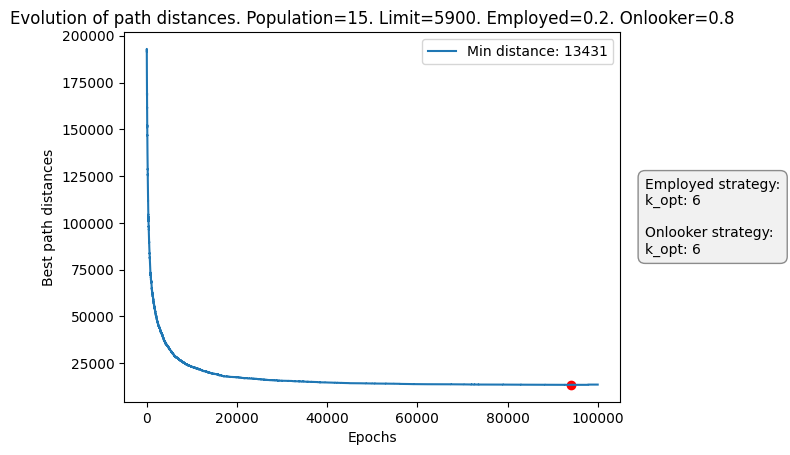

In [38]:
title = f'Evolution of path distances. Population={population}. Limit={limit}. Employed={employed_porcentaje}. Onlooker={onlooker_percentaje}'


history_best_paths_distances(paths_distances, employed_mutation_strategy + ": " + str(k_employed), onlooker_mutation_strategy+ ": " + str(k_employed), title=title)


Total improvement over the entire training: 120649.00 units of distance (62.00%)


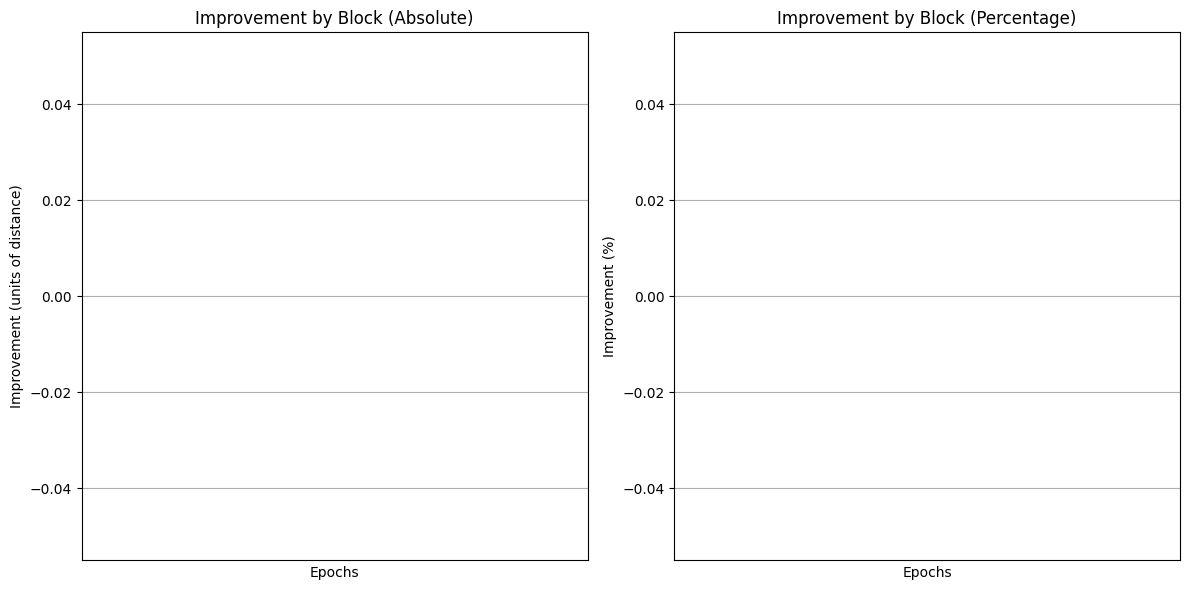

In [15]:
info_training(1000, paths_distances)

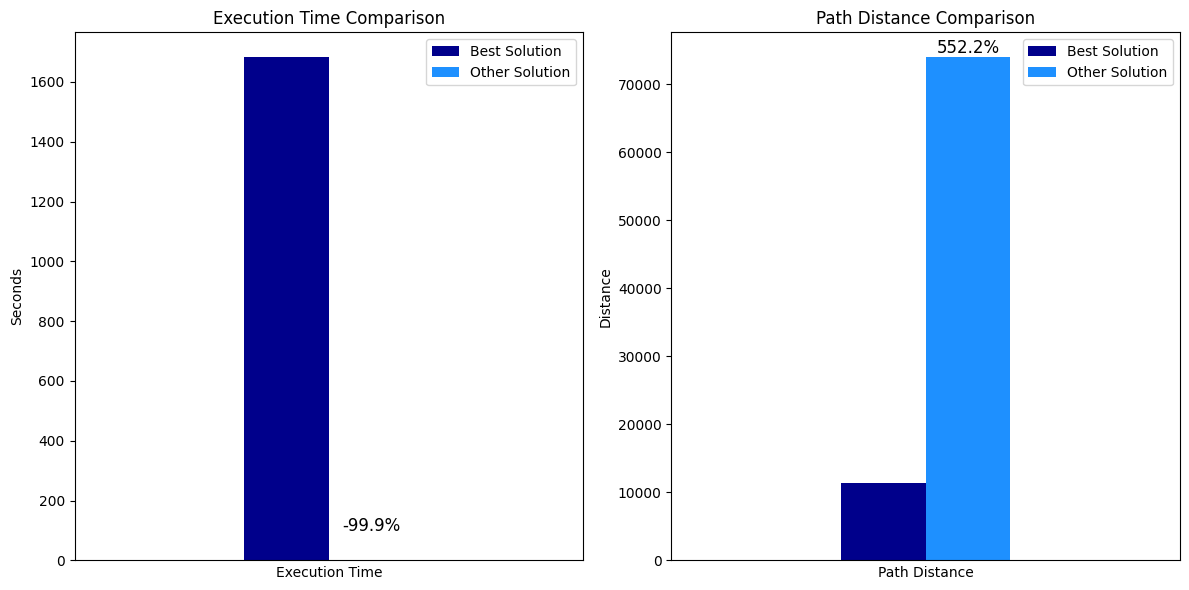

In [16]:
best_solution = [1681.68, 11340]
other_solution = [execution_time, final_best_path_distance]
plot_comparison(best_solution, other_solution)

## Find best hyper parameters

In [30]:
ini_end_city = 0

# Define hyperparameters to search
param_grid = {
    "population": [50, 100],
    "employed_percentage": [0.5, 0.7],
    "limit": [100, 200],
    "epochs": [1000, 2000],
    "employed_mutation_strategy": ['insertion', 'k_opt'],
    "onlooker_mutation_strategy": ['insertion', 'k_opt'],
    "k_employed": [3,4],
    "k_onlooker": [3,4]
}

# Run grid search abc
results = abc_tsp.ArtificialBeeColonyOptimizer.grid_search_abc(
    distance_matrix=distance_matrix,
    ini_end_city=ini_end_city,
    param_grid=param_grid,
    n_jobs=-1,
    refit=False
)

In [32]:
print(results.keys())

if "execution_time" in results:
    print("\nMin path distance: ", results['final_best_path_distance'])
    print("Time taken to train: ", results['execution_time'])
    print("The best path found is: \n", results['final_best_path'])
    
else:
    print("\nBest hiperparameters found:\n", results['best_params'])
    print("Distance of the best path found with this hiperparameters:", results['best_distance'])

dict_keys(['best_params', 'best_distance'])

Best hiperparameters found:
 {'population': 50, 'employed_percentage': 0.5, 'limit': 100, 'epochs': 2000, 'employed_mutation_strategy': 'k_opt', 'onlooker_mutation_strategy': 'k_opt', 'k_employed': 4, 'k_onlooker': 3}
Distance of the best path found with this hiperparameters: 57056


## References

Karaboğa, D. (2005). *An idea based on honey bee swarm for numerical optimization*. Technical Report-TR06, Erciyes University, Engineering Faculty, Computer Engineering Department.